In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
from keras import layers, Sequential
from keras.models import Model
from keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam, SGD, Adagrad, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras import initializers
import os
from tensorflow.keras.preprocessing import image_dataset_from_directory
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import matplotlib.pyplot as plt

#### Reading the data, normalizing and flattening it

##### Reading and Normalizing

In [12]:

train = image_dataset_from_directory(
    'Group_24/train/',
    labels='inferred',
    label_mode='int',
    batch_size=1,
    image_size=(28, 28),
    shuffle=True,
    seed=42,
    color_mode='grayscale',
    validation_split=0.0
)

val = image_dataset_from_directory(
    'Group_24/val/',
    labels='inferred',
    label_mode='int',
    batch_size=1,
    image_size=(28, 28),
    shuffle=True,
    seed=42,
    color_mode='grayscale',
    validation_split=0.0
)

test = image_dataset_from_directory(
    'Group_24/test/',
    labels='inferred',
    label_mode='int',
    batch_size=1,
    image_size=(28, 28),
    shuffle=True,
    seed=42,
    color_mode='grayscale',
    validation_split=0.0
)

def normalize(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image, label

train = train.map(normalize)
val = val.map(normalize)
test = test.map(normalize)

Found 11385 files belonging to 5 classes.
Found 3795 files belonging to 5 classes.
Found 3795 files belonging to 5 classes.


##### Flattening

Preparing training tensors

In [13]:
# Iterate through the dataset and reshape each image tensor
image_tensors = []
label_tensors = []
for image, labels in train:
    num_images = image.shape[0]
    image_vectors = tf.reshape(image, [num_images, -1])
    image_tensors.append(image_vectors)
    label_tensors.append(labels)

# Concatenate the image tensors into a single tensor
train_vectors = [tf.concat(image_tensors, axis=0), tf.concat(label_tensors, axis=0)]

Preparing validation tensors

In [14]:
# Iterate through the dataset and reshape each image tensor
image_tensors = []
label_tensors = []
for image, labels in val:
    num_images = image.shape[0]
    image_vectors = tf.reshape(image, [num_images, -1])
    image_tensors.append(image_vectors)
    label_tensors.append(labels)

# Concatenate the image tensors into a single tensor
val_vectors = [tf.concat(image_tensors, axis=0), tf.concat(label_tensors, axis=0)]

Preparing testing tensors

In [15]:
# Iterate through the dataset and reshape each image tensor
image_tensors = []
label_tensors = []
for image, labels in test:
    num_images = image.shape[0]
    image_vectors = tf.reshape(image, [num_images, -1])
    image_tensors.append(image_vectors)
    label_tensors.append(labels)

# Concatenate the image tensors into a single tensor
test_vectors = [tf.concat(image_tensors, axis=0), tf.concat(label_tensors, axis=0)]

#### 20% noise autoencoder

In [ ]:
print("Training a 20 percent denoising autoencoder with 32 neurons in bottleneck layer")
inputs = tf.keras.layers.Input(shape=(784,))
hidden_layer = tf.keras.layers.Dense(
    units=32, activation=tf.nn.sigmoid)(inputs)
outputs = tf.keras.layers.Dense(units=784, activation=tf.nn.relu)(hidden_layer)
autoencoder = tf.keras.models.Model(inputs=inputs, outputs=outputs)

# Define the loss function as the squared difference between the output and original input


def custom_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))


adam_optimizer = Adam(learning_rate=0.001, beta_1=0.9,
                      beta_2=0.999, epsilon=1e-8)
autoencoder.compile(optimizer=adam_optimizer, loss=custom_loss,  metrics=['mse'])

# Define the noise function that adds noise to the input data


def add_noise(inputs, noise_probability):
    mask = np.random.binomial(n=1, p=noise_probability, size=inputs.shape)
    noise = np.random.normal(size=inputs.shape)
    noisy_inputs = inputs * (1 - mask) + noise * mask
    return noisy_inputs


early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=1e-4,patience=5, verbose=0, restore_best_weights=True)
tensorboard_callback = TensorBoard(
    log_dir=f'./logdir/Q5/Denoising_20per_32_neurons/')

for epoch in range(1000):
    # print('Epoch:', epoch+1)
    epoch += 1
    noisy_train_data = add_noise(train_vectors[0].numpy(), 0.2)
    model_fit = autoencoder.fit(noisy_train_data, train_vectors[0].numpy(), batch_size=len(train_vectors[0].numpy()), epochs=1, validation_split=0.0, validation_data=(
        val_vectors[0].numpy(), val_vectors[0].numpy()), callbacks=[early_stop, tensorboard_callback], verbose=0, shuffle=True, validation_batch_size=None)

hist_metric = 'mse'
print(
    f'epochs: {len(model_fit.history[hist_metric])}, mse: {model_fit.history[hist_metric][-1]}\n')
autoencoder.save(f'models/Q5/Denoising_20per_32_neurons.tf')


##### Displaying reconstructed image for training data

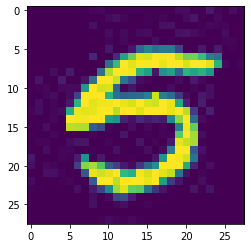

In [24]:
plt.imshow(train_vectors[0].numpy()[0].reshape(28,28))

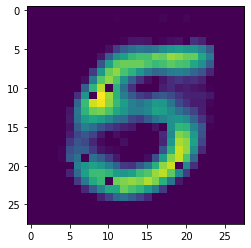

In [32]:
trained_model = tf.keras.models.load_model("models\Q5\Denoising_20per_32_neurons.tf", custom_objects={'custom_loss': custom_loss})
predictions = trained_model.predict(train_vectors[0].numpy()[0].reshape(1,784))
plt.imshow(predictions.reshape(28,28))

##### Displaying reconstructed images for validation data

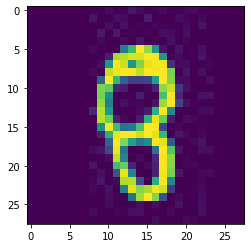

In [33]:
plt.imshow(val_vectors[0].numpy()[0].reshape(28,28))

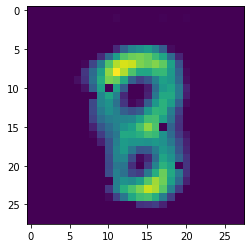

In [34]:
trained_model = tf.keras.models.load_model("models\Q5\Denoising_20per_32_neurons.tf", custom_objects={'custom_loss': custom_loss})
predictions = trained_model.predict(val_vectors[0].numpy()[0].reshape(1,784))
plt.imshow(predictions.reshape(28,28))

##### Displaying reconstructed images for testing data

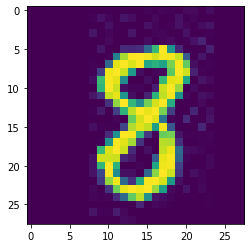

In [35]:
plt.imshow(test_vectors[0].numpy()[0].reshape(28,28))

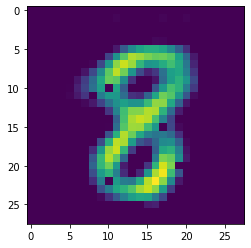

In [36]:
trained_model = tf.keras.models.load_model("models\Q5\Denoising_20per_32_neurons.tf", custom_objects={'custom_loss': custom_loss})
predictions = trained_model.predict(test_vectors[0].numpy()[0].reshape(1,784))
plt.imshow(predictions.reshape(28,28))

#### 40% noise autoencoder

In [41]:
print("Training a 40 percent denoising autoencoder with 32 neurons in bottleneck layer")
inputs = tf.keras.layers.Input(shape=(784,))
hidden_layer = tf.keras.layers.Dense(
    units=32, activation=tf.nn.sigmoid)(inputs)
outputs = tf.keras.layers.Dense(units=784, activation=tf.nn.relu)(hidden_layer)
autoencoder = tf.keras.models.Model(inputs=inputs, outputs=outputs)

# Define the loss function as the squared difference between the output and original input


def custom_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))


adam_optimizer = Adam(learning_rate=0.001, beta_1=0.9,
                      beta_2=0.999, epsilon=1e-8)
autoencoder.compile(optimizer=adam_optimizer, loss=custom_loss,  metrics=['mse'])

# Define the noise function that adds noise to the input data


def add_noise(inputs, noise_probability):
    mask = np.random.binomial(n=1, p=noise_probability, size=inputs.shape)
    noise = np.random.normal(size=inputs.shape)
    noisy_inputs = inputs * (1 - mask) + noise * mask
    return noisy_inputs


early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=1e-4,patience=5, verbose=0, restore_best_weights=True)
tensorboard_callback = TensorBoard(
    log_dir=f'./logdir/Q5/Denoising_40per_32_neurons/')

for epoch in range(1000):
    # print('Epoch:', epoch+1)
    epoch += 1
    noisy_train_data = add_noise(train_vectors[0].numpy(), 0.4)
    model_fit = autoencoder.fit(noisy_train_data, train_vectors[0].numpy(), batch_size=len(train_vectors[0].numpy()), epochs=1, validation_split=0.0, validation_data=(
        val_vectors[0].numpy(), val_vectors[0].numpy()), callbacks=[early_stop, tensorboard_callback], verbose=0, shuffle=True, validation_batch_size=None)

hist_metric = 'mse'
print(
    f'epochs: {len(model_fit.history[hist_metric])}, mse: {model_fit.history[hist_metric][-1]}\n')
autoencoder.save(f'models/Q5/Denoising_40per_32_neurons.tf')


Training a 40 percent denoising autoencoder with 32 neurons in bottleneck layer
epochs: 1, mse: 0.033603180199861526



##### Displaying reconstructed image for training data

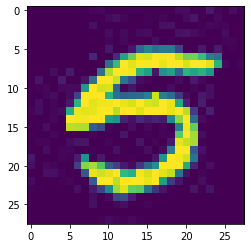

In [ ]:
plt.imshow(train_vectors[0].numpy()[0].reshape(28,28))

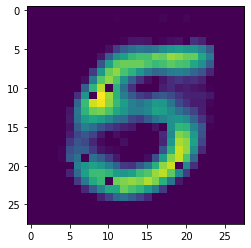

In [ ]:
trained_model = tf.keras.models.load_model("models\Q5\Denoising_40per_32_neurons.tf", custom_objects={'custom_loss': custom_loss})
predictions = trained_model.predict(train_vectors[0].numpy()[0].reshape(1,784))
plt.imshow(predictions.reshape(28,28))

##### Displaying reconstructed images for validation data

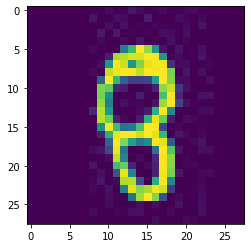

In [ ]:
plt.imshow(val_vectors[0].numpy()[0].reshape(28,28))

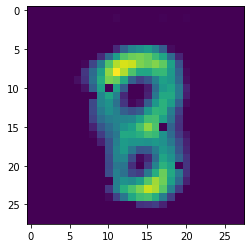

In [ ]:
trained_model = tf.keras.models.load_model("models\Q5\Denoising_40per_32_neurons.tf", custom_objects={'custom_loss': custom_loss})
predictions = trained_model.predict(val_vectors[0].numpy()[0].reshape(1,784))
plt.imshow(predictions.reshape(28,28))

##### Displaying reconstructed images for testing data

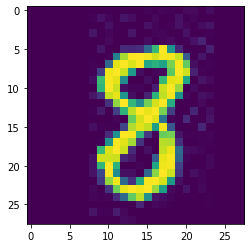

In [ ]:
plt.imshow(test_vectors[0].numpy()[0].reshape(28,28))

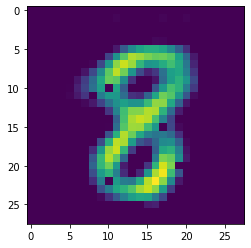

In [ ]:
trained_model = tf.keras.models.load_model("models\Q5\Denoising_40per_32_neurons.tf", custom_objects={'custom_loss': custom_loss})
predictions = trained_model.predict(test_vectors[0].numpy()[0].reshape(1,784))
plt.imshow(predictions.reshape(28,28))

#### Making a classifier with the reduced representation

In [37]:
def get_reduced_representation(noise, vec):
    models = os.listdir('./models/Q5')
    model_path = str
    for model in models:
        if( (str(noise)+"per") in model) : model_path = model
    loaded_model = tf.keras.models.load_model(os.path.join('./models/Q5', model_path), custom_objects={'custom_loss': custom_loss})
    hidden_layer_model = tf.keras.models.Model(inputs=loaded_model.input, outputs=loaded_model.layers[1].output)
    hidden_output = hidden_layer_model.predict(vec[0].numpy().reshape(len(vec[0]),784))
    return hidden_output

##### 20 percent denoised reduced representation classification model

In [38]:
model_arch = [
    [96, 64, 32],
    [64, 96, 128],
    [128, 96, 64],
    [256, 128, 96]
]
initializer = initializers.RandomNormal(mean=0.0, stddev=0.05, seed=42)

k=5 # no. of classes
model_history = dict()

# train different achitectures and optimizers
print('Training models with different architectures')
reduced_rep_train = get_reduced_representation(20, train_vectors)
reduced_rep_val = get_reduced_representation(20, val_vectors)
for layer_dims in model_arch:
    print(f'20 percent noise-{layer_dims[0]}-{layer_dims[1]}-{layer_dims[2]}...')
    # define model
    model = Sequential([
        layers.Dense(32, activation="relu", input_shape=(32,)),
        # keras.Input(input_shape=(reduced_dimension,)),
        layers.Dense(layer_dims[0], activation="sigmoid", name="layer1", 
                        kernel_initializer=initializer, bias_initializer=initializers.Zeros()),
        layers.Dense(layer_dims[1], activation="sigmoid", name="layer2", 
                        kernel_initializer=initializer, bias_initializer=initializers.Zeros()),
        layers.Dense(layer_dims[2], activation="sigmoid", name="layer3", 
                        kernel_initializer=initializer, bias_initializer=initializers.Zeros()),
        # layers.Dense(layer_dims[3], activation="sigmoid", name="layer4", 
        #              kernel_initializer=initializer, bias_initializer=initializers.Zeros()),
        layers.Dense(k, activation="softmax", name="output", 
                        kernel_initializer=initializer, bias_initializer=initializers.Zeros()),
    ])
    
    # compile model
    adam_optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
    model.compile(optimizer=adam_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # callbacks
    my_callbacks = [
        EarlyStopping(monitor='val_loss', min_delta=1e-7, patience=10),
        TensorBoard(log_dir=f'./logdir/Q5/classifier/20per-32-{layer_dims[0]}-{layer_dims[1]}-{layer_dims[2]}/')
    ]
    model_fit = model.fit(reduced_rep_train, train_vectors[1].numpy(), batch_size=len(train_vectors[0]), epochs=10000, verbose=0, callbacks=my_callbacks, 
                            validation_split=0.0, validation_data=(reduced_rep_val, val_vectors[1].numpy()), shuffle=True, validation_batch_size=None)
    
    hist_metric = 'accuracy'
    print(f'epochs: {len(model_fit.history[hist_metric])}, acc: {model_fit.history[hist_metric][-1]}\n')
    model.save(f'models/Q5/classifier/20per-32-{layer_dims[0]}-{layer_dims[1]}-{layer_dims[2]}.tf')



Training models with different architectures
20 percent noise-96-64-32...
epochs: 1149, acc: 0.9953447580337524

20 percent noise-64-96-128...
epochs: 816, acc: 0.9874396324157715

20 percent noise-128-96-64...
epochs: 926, acc: 0.991567850112915

20 percent noise-256-128-96...
epochs: 750, acc: 0.990338146686554



##### 40 percent denoised reduced representation classification model

In [42]:
model_arch = [
    [96, 64, 32],
    [64, 96, 128],
    [128, 96, 64],
    [256, 128, 96]
]
initializer = initializers.RandomNormal(mean=0.0, stddev=0.05, seed=42)

k=5 # no. of classes
model_history = dict()

# train different achitectures and optimizers
print('Training models with different architectures')
reduced_rep_train = get_reduced_representation(40, train_vectors)
reduced_rep_val = get_reduced_representation(40, val_vectors)
for layer_dims in model_arch:
    print(f'20 percent noise-{layer_dims[0]}-{layer_dims[1]}-{layer_dims[2]}...')
    # define model
    model = Sequential([
        layers.Dense(32, activation="relu", input_shape=(32,)),
        # keras.Input(input_shape=(reduced_dimension,)),
        layers.Dense(layer_dims[0], activation="sigmoid", name="layer1", 
                        kernel_initializer=initializer, bias_initializer=initializers.Zeros()),
        layers.Dense(layer_dims[1], activation="sigmoid", name="layer2", 
                        kernel_initializer=initializer, bias_initializer=initializers.Zeros()),
        layers.Dense(layer_dims[2], activation="sigmoid", name="layer3", 
                        kernel_initializer=initializer, bias_initializer=initializers.Zeros()),
        # layers.Dense(layer_dims[3], activation="sigmoid", name="layer4", 
        #              kernel_initializer=initializer, bias_initializer=initializers.Zeros()),
        layers.Dense(k, activation="softmax", name="output", 
                        kernel_initializer=initializer, bias_initializer=initializers.Zeros()),
    ])
    
    # compile model
    adam_optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
    model.compile(optimizer=adam_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # callbacks
    my_callbacks = [
        EarlyStopping(monitor='val_loss', min_delta=1e-7, patience=10),
        TensorBoard(log_dir=f'./logdir/Q5/classifier/40per-32-{layer_dims[0]}-{layer_dims[1]}-{layer_dims[2]}/')
    ]
    model_fit = model.fit(reduced_rep_train, train_vectors[1].numpy(), batch_size=len(train_vectors[0]), epochs=10000, verbose=0, callbacks=my_callbacks, 
                            validation_split=0.0, validation_data=(reduced_rep_val, val_vectors[1].numpy()), shuffle=True, validation_batch_size=None)
    
    hist_metric = 'accuracy'
    print(f'epochs: {len(model_fit.history[hist_metric])}, acc: {model_fit.history[hist_metric][-1]}\n')
    model.save(f'models/Q5/classifier/40per-32-{layer_dims[0]}-{layer_dims[1]}-{layer_dims[2]}.tf')



Training models with different architectures
20 percent noise-96-64-32...
epochs: 1461, acc: 0.9892841577529907

20 percent noise-64-96-128...
epochs: 1091, acc: 0.9886692762374878

20 percent noise-128-96-64...
epochs: 914, acc: 0.9862977862358093

20 percent noise-256-128-96...
epochs: 796, acc: 0.9897233247756958

